# <center>Map for rat data</center>

In this guidebook, we will provide a step-by-step explanation of utilizing our library to compute the correlation between various brain regions for a specific rat. We will explore diverse types of estimators during the process.

In [1]:
# necessary librairies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import some functions necessary to process the different files needed
from itertools import combinations
from processing_1 import process_region
from processing_1 import get_all_files_in_folder_matching_number
from processing_1 import estimators_corr

## 1. Get rat files that would be used :

Firstly, we will introduce the necessary data for our analysis. We require three specific types of files: a file containing the voxel coordinates for each brain region, a file containing the wavelet-transformed time series data for each individual brain region, and a file containing the respective weights assigned to each region. 


In this first code, we will retrieve the data files for regions 52 and 53, which correspond to the two regions that exhibit no correlation between themselves and the other regions. Furthermore, we will select the specific regions for which we want to calculate the correlations and obtain the corresponding files.

In [3]:
# The folder that contains files from which we want to get data
folder_path = "/Users/ossamaziri/Desktop/Ensimag/StageIA/ratdatapreprocessing/RatDataPreprocessed/EtoL/20160616_103405_fmri_flat/preprocessed_20160616_103405/"

# path to the data of regions 3 and 4 that would be used in estimators D, RD, lD, lRD
Y_path_region_52 = folder_path + 'dwt_ts_ROI_52.txt'
Y_path_region_53 = folder_path + 'dwt_ts_ROI_53.txt'

weights_path_region_52 = folder_path + 'weight_ROI_52.txt'
weights_path_region_53 = folder_path + 'weight_ROI_53.txt'

coords_path_region_52 = folder_path + 'coord_ROI_52.txt'
coords_path_region_53 = folder_path + 'coord_ROI_53.txt'

data_region_52 = process_region(Y_path_region_52, coords_path_region_52, weights_path_region_52)
data_region_53 = process_region(Y_path_region_53, coords_path_region_53, weights_path_region_53)

# data of the 4 regions that would be given to the estimators to compute correlation
# the two regions of interest will be each time the first elements of this array
# regions 3 and 4 will remain the same for all pairs of regions
data  = [{}, {}, data_region_52, data_region_53]

# numbers of the regions that we will use to calculate the correlation.
numbers = [1, 2, 7, 10, 11, 16, 18, 21, 24, 25, 30, 32, 37, 39, 41, 43, 48, 50]
number_of_regions = len(numbers)

# a dictionnary that contains paths of Y, coords and w of these regions 
paths = get_all_files_in_folder_matching_number(folder_path, numbers)

## 2. Matrices of correlations for different estimators 

At this stage, we proceed to calculate the correlations between all regions using the `estCorr` function for each estimator. As a result, we obtain a dictionary that contains ten correlation matrices, one for each of the ten methods employed.

In [4]:
# array of all possible combinations of 2 regions
combinations_of_2_regions = list(combinations([i for i in range(len(numbers))], 2))

# matrix of correlation between regions 
matrix_of_corr = np.zeros((number_of_regions, number_of_regions))

# estimators
estimators = ["CA", "AC", "ACc", "lCA", "R", "lR", "D", "lD", "RD", "lRD"]

# a dictionnary that associate an estimator to the matrix of correlation between regions
# using that estimator
dict_estimator_matrix_of_corr = {}
for estimator in estimators:
    dict_estimator_matrix_of_corr[estimator] = np.zeros((number_of_regions, number_of_regions))


# loop to calculate correlations between regions
for index_region_1, index_region_2 in combinations_of_2_regions:
    # first region 
    data_index_region_1 = process_region(Y_path=paths['Y_paths'][index_region_1],
                                         coords_path=paths['coords_paths'][index_region_1],
                                         weights_path=paths['weights_paths'][index_region_1])
    # second region
    data_index_region_2 = process_region(Y_path=paths['Y_paths'][index_region_2],
                                         coords_path=paths['coords_paths'][index_region_2],
                                         weights_path=paths['weights_paths'][index_region_2])
    # putting data of first and second regions in the first and second index of the list "data"
    # that will contain data of the 4 regions
    data[0], data[1] = data_index_region_1, data_index_region_2
    # data frame  of estimators and their correlations
    corr_DF = estimators_corr(data, estimators=estimators)
    for estimator in estimators:
        # correlation between the 2 regions
        correlation_of_2_regions = corr_DF.loc[corr_DF['EST'] == estimator, 'CORR'].values[0]
        # filling the matrix of correlation of that estimator with the calculated correlation
        dict_estimator_matrix_of_corr[estimator][index_region_1, index_region_2] = correlation_of_2_regions
        dict_estimator_matrix_of_corr[estimator][index_region_2, index_region_1] = correlation_of_2_regions

As an example, we choose to display the correlation matrix associated with the "Correlation of Averages" method (CA). This method is determined by the following formula:

$r_{jj'} = \frac{\text{Cov}(\bar{Y}_{Rj}, \bar{Y}_{Rj'})}{\sigma(\bar{Y}_{Rj})\sigma(\bar{Y}_{Rj'})}$

where $\text{Cov}$ represents covariance, $\bar{Y}_{Rj}$ and $\bar{Y}_{Rj'}$ are variables denoting specific brain regions, and $\sigma$ denotes standard deviation.

In [5]:
# Create a DataFrame from the matrix
df = pd.DataFrame(dict_estimator_matrix_of_corr["CA"])

# Display the DataFrame
df

0         1         2         3         4         5         6   \
0   0.000000  0.391371  0.323140  0.300489  0.542905  0.270353  0.422184   
1   0.391371  0.000000  0.373516  0.384181  0.418521  0.264319  0.324117   
2   0.323140  0.373516  0.000000  0.744823  0.472256  0.252841  0.455002   
3   0.300489  0.384181  0.744823  0.000000  0.487307  0.186819  0.478937   
4   0.542905  0.418521  0.472256  0.487307  0.000000  0.237367  0.352013   
5   0.270353  0.264319  0.252841  0.186819  0.237367  0.000000  0.250837   
6   0.422184  0.324117  0.455002  0.478937  0.352013  0.250837  0.000000   
7   0.668337  0.458807  0.522772  0.451703  0.553473  0.393643  0.535933   
8   0.538445  0.470161  0.547811  0.443869  0.552499  0.442180  0.511006   
9   0.538790  0.373651  0.498982  0.495580  0.552642  0.297391  0.608461   
10  0.623055  0.365260  0.264142  0.265957  0.545257  0.222257  0.327348   
11  0.576701  0.373685  0.405979  0.388809  0.521956  0.330162  0.455701   
12  0.227284  0.110101  0.006111 -0.027832  0.223342  0.059180  0.012221   
13  0.479482  0.312763  0.244873  0.206383  0.487661  0.228449  0.263392   
14  0.529504  0.336608  0.322024  0.309480  0.444453  0.222702  0.445570   
15  0.560955  0.359755  0.400211  0.364287  0.481164  0.329728  0.512567   
16  0.243765  0.145047  0.138070  0.180665  0.233182  0.219009  0.282418   
17  0.465784  0.257906  0.320620  0.267033  0.404990  0.301789  0.410163   

          7         8         9         10        11        12        13  \
0   0.668337  0.538445  0.538790  0.623055  0.576701  0.227284  0.479482   
1   0.458807  0.470161  0.373651  0.365260  0.373685  0.110101  0.312763   
2   0.522772  0.547811  0.498982  0.264142  0.405979  0.006111  0.244873   
3   0.451703  0.443869  0.495580  0.265957  0.388809 -0.027832  0.206383   
4   0.553473  0.552499  0.552642  0.545257  0.521956  0.223342  0.487661   
5   0.393643  0.442180  0.297391  0.222257  0.330162  0.059180  0.228449   
6   0.535933  0.511006  0.608461  0.327348  0.455701  0.012221  0.263392   
7   0.000000  0.730626  0.665703  0.535531  0.603211  0.101829  0.443566   
8   0.730626  0.000000  0.695513  0.496719  0.570457  0.079484  0.420414   
9   0.665703  0.695513  0.000000  0.457338  0.530521  0.064638  0.412539   
10  0.535531  0.496719  0.457338  0.000000  0.646699  0.459212  0.551521   
11  0.603211  0.570457  0.530521  0.646699  0.000000  0.230474  0.582900   
12  0.101829  0.079484  0.064638  0.459212  0.230474  0.000000  0.250805   
13  0.443566  0.420414  0.412539  0.551521  0.582900  0.250805  0.000000   
14  0.531980  0.504419  0.529038  0.523114  0.525813  0.189942  0.444045   
15  0.616031  0.575860  0.564144  0.564465  0.725048  0.156567  0.604997   
16  0.313016  0.302275  0.305547  0.332913  0.312113  0.237926  0.267524   
17  0.495965  0.462286  0.522802  0.466576  0.596310  0.113021  0.692600   

          14        15        16        17  
0   0.529504  0.560955  0.243765  0.465784  
1   0.336608  0.359755  0.145047  0.257906  
2   0.322024  0.400211  0.138070  0.320620  
3   0.309480  0.364287  0.180665  0.267033  
4   0.444453  0.481164  0.233182  0.404990  
5   0.222702  0.329728  0.219009  0.301789  
6   0.445570  0.512567  0.282418  0.410163  
7   0.531980  0.616031  0.313016  0.495965  
8   0.504419  0.575860  0.302275  0.462286  
9   0.529038  0.564144  0.305547  0.522802  
10  0.523114  0.564465  0.332913  0.466576  
11  0.525813  0.725048  0.312113  0.596310  
12  0.189942  0.156567  0.237926  0.113021  
13  0.444045  0.604997  0.267524  0.692600  
14  0.000000  0.638489  0.425078  0.464599  
15  0.638489  0.000000  0.388775  0.690183  
16  0.425078  0.388775  0.000000  0.297312  
17  0.464599  0.690183  0.297312  0.000000

## 3. Visualization of correlations

Next, we will employ various visualization techniques such as beewarm plots, box plots, and violin plots to depict the distinct matrices of correlations.

### 3.1 Beeswarm Plot

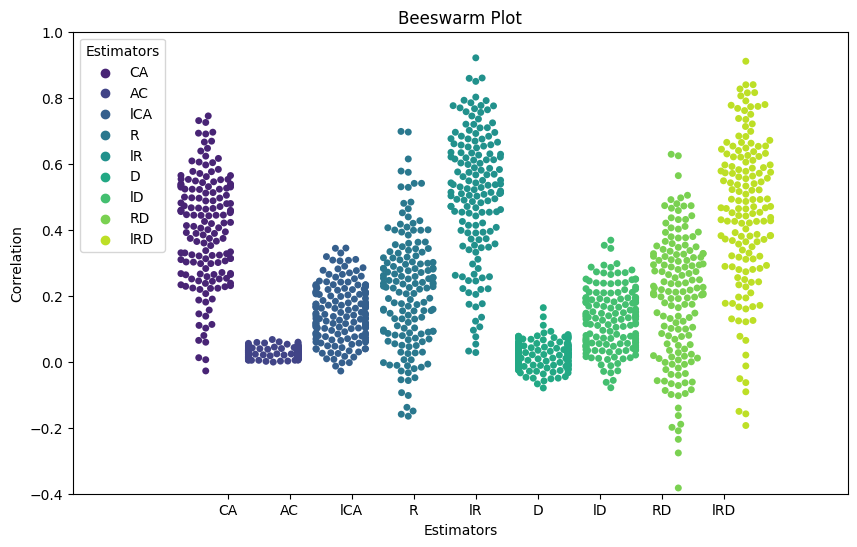

In [6]:
#Recuperate the correlation matrixes
corr_CA = dict_estimator_matrix_of_corr["CA"]
corr_AC = dict_estimator_matrix_of_corr["AC"]
corr_ACc = dict_estimator_matrix_of_corr["ACc"]
corr_lCA = dict_estimator_matrix_of_corr["lCA"]
corr_R = dict_estimator_matrix_of_corr["R"]
corr_lR = dict_estimator_matrix_of_corr["lR"]
corr_D = dict_estimator_matrix_of_corr["D"]
corr_lD = dict_estimator_matrix_of_corr["lD"]
corr_RD = dict_estimator_matrix_of_corr["RD"]
corr_lRD = dict_estimator_matrix_of_corr["lRD"]

# List of correlation matrices and corresponding names
correlation_matrices = [corr_CA, corr_AC, corr_ACc, corr_lCA, corr_R, corr_lR, corr_D, corr_lD, corr_RD, corr_lRD]
names = ["CA", "AC", "ACc", "lCA", "R", "lR", "D", "lD", "RD", "lRD"]

upper_triangular_values = []
correlation_names = []

# Iterate through each correlation matrix
for matrix, name in zip(correlation_matrices, names):
    # Get the strict upper triangular values
    upper_triangular = matrix[np.triu_indices(matrix.shape[0], k=1)].flatten()
    # Append values and corresponding name
    upper_triangular_values.extend(upper_triangular)
    correlation_names.extend([name] * len(upper_triangular))

# Create a dataframe
df = pd.DataFrame({'EST': correlation_names, 'CORR': upper_triangular_values})

# Extract the necessary columns from df
labs_color = df[df['EST'] != "ACc"]['EST']

# Create a copy of the data with modified Estimators
data = df[df['EST'] != "ACc"].copy()
data['Estimators'] = data['EST'].replace({
    "agg": "CA",
    "ave": "AC",
    "laveB": "ℓCA",
    "raveB": "R",
    "lraveB": "ℓR",
    "saveB": "D",
    "slaveB": "ℓD",
    "sraveB": "RD",
    "slraveB": "ℓRD",
})


plt.figure(figsize=(10, 6))  # Adjust the figure size as desired

bee_live = sns.swarmplot(data=data, x='Estimators', y='CORR', hue='Estimators', dodge=True, palette='viridis')
bee_live.set(ylim=(-0.4, 1))
bee_live.set(xlim=(-2.5, 10))
bee_live.set_xlabel('Estimators')
bee_live.set_ylabel('Correlation')
bee_live.set_title('Beeswarm Plot')

# Display the plot
plt.show()

### 3.2 Box Plot

In [7]:
# Create a dictionary to store the data for each estimator
estimator_data = {}

# Iterate through each estimator
for estimator in data['Estimators'].unique():
    # Get the correlation values for the current estimator
    correlations = data[data['Estimators'] == estimator]['CORR']
    # Store the correlations in the dictionary
    estimator_data[estimator] = correlations

# Convert the dictionary to a list of lists for boxplot
boxplot_data = list(estimator_data.values())

# Create the boxplot
plt.boxplot(boxplot_data, labels=list(estimator_data.keys()), patch_artist=True)

# Set the labels and title
plt.xlabel('Estimators')
plt.ylabel('Correlation')
plt.title('Boxplot')

# Display the plot
plt.show()

### 3.3 Violin Plot 

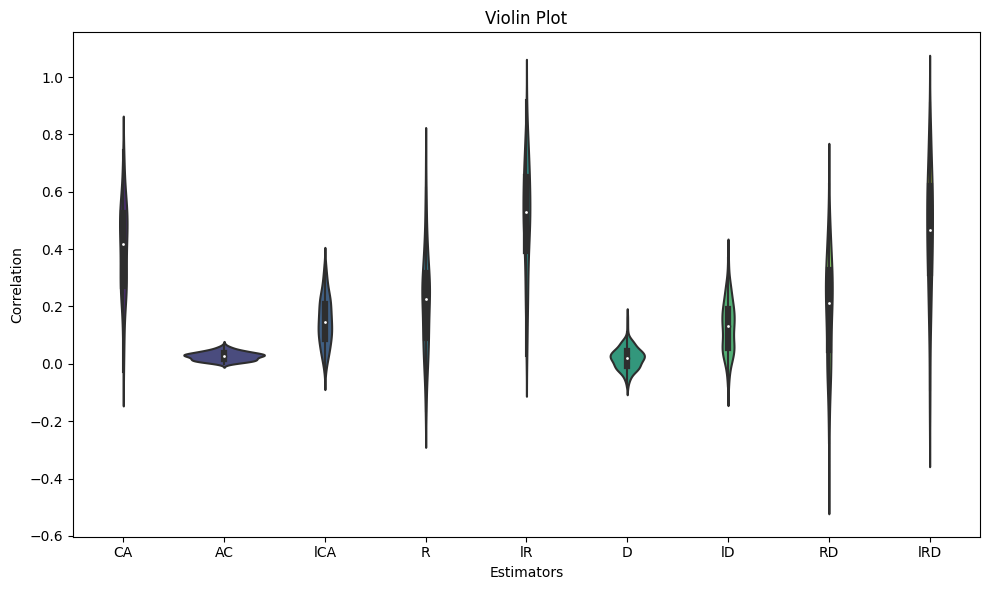

In [8]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the violin plot with adjusted width
sns.violinplot(data=data, x='Estimators', y='CORR', palette='viridis', width=0.8)

# Set the labels and title
plt.xlabel('Estimators')
plt.ylabel('Correlation')
plt.title('Violin Plot')

# Adjust the padding
plt.tight_layout()

# Display the plot
plt.show()

## 4. Graph metrics for the correlation matrix of each estimator

In this specific section, we will make use of the previously computed correlation matrix.


Our primary objective is to apply a thresholding technique to this correlation matrix. Thresholding involves establishing a specific threshold value, below which any correlation value will be considered insignificant or weak. By implementing thresholding, we effectively filter out weaker correlations and focus solely on the more significant ones.


Following the application of the thresholding process, we will proceed to extract a minimum spanning tree (MST) from the resulting correlation matrix. A minimum spanning tree represents a graph that connects all the variables while minimizing the total sum of edge weights. In the context of the correlation matrix, a MST provides a simplified representation of the strongest and most essential connections between the brain regions.


By extracting a minimum spanning tree from the thresholded correlation matrix, we can successfully identify the most significant relationships and dependencies among the brain regions. This approach allows us to streamline complexity and gain insights into the fundamental connections within the dataset.


To carry out these operations, we will utilize the compute_graph function. This function will return the resulting adjacency matrix, which represents the connections between brain regions, along with a series of graph metrics that describe the characteristics of the graph derived from this adjacency matrix.

In [9]:
# import the function to compute the metrics
from function_compute_graphs import compute_graphs

In [10]:
dict_metrics_estimators = {}
for estimator in estimators:
    cor_mat = dict_estimator_matrix_of_corr[estimator]
    metrics = compute_graphs(cor_mat=cor_mat, cost_percentage=0.2)
    dict_metrics_estimators[estimator] = metrics

30.0
30.0
30.0
30.0
30.0
30.0
30.0
30.0
30.0
30.0


### 4.1 Putting graph metrics in lists to be plotted

In [11]:
betweeenness_list = [dict_metrics_estimators[estimator]["betweenness_centrality"] for estimator in estimators]
betweeenness_unw_list = [dict_metrics_estimators[estimator]["betweenness_unw"] for estimator in estimators]
weighted_degree_list = [dict_metrics_estimators[estimator]["weighted_degree"] for estimator in estimators]
global_efficiency_list = [dict_metrics_estimators[estimator]["res_Eglob"] for estimator in estimators]
local_efficiency_list = [dict_metrics_estimators[estimator]["res_Eloc"] for estimator in estimators]
weighted_transitivity_list = [dict_metrics_estimators[estimator]["res_transitivity"] for estimator in estimators]
strength_list = [dict_metrics_estimators[estimator]["res_strength"] for estimator in estimators]
degree_list = [dict_metrics_estimators[estimator]["res_degree"] for estimator in estimators]
maximum_list = [dict_metrics_estimators[estimator]["res_max"] for estimator in estimators]
# Filter non-NaN values from the weighted transitivities in weighted_transitivity_list
for i in range(len(weighted_transitivity_list)):
    nonnan_mask = ~np.isnan(weighted_transitivity_list[i])
    nonnan_values = np.array(weighted_transitivity_list[i])[nonnan_mask]
    weighted_transitivity_list[i] = nonnan_values

### 4.2 Visualization of graph metrics for different estimators

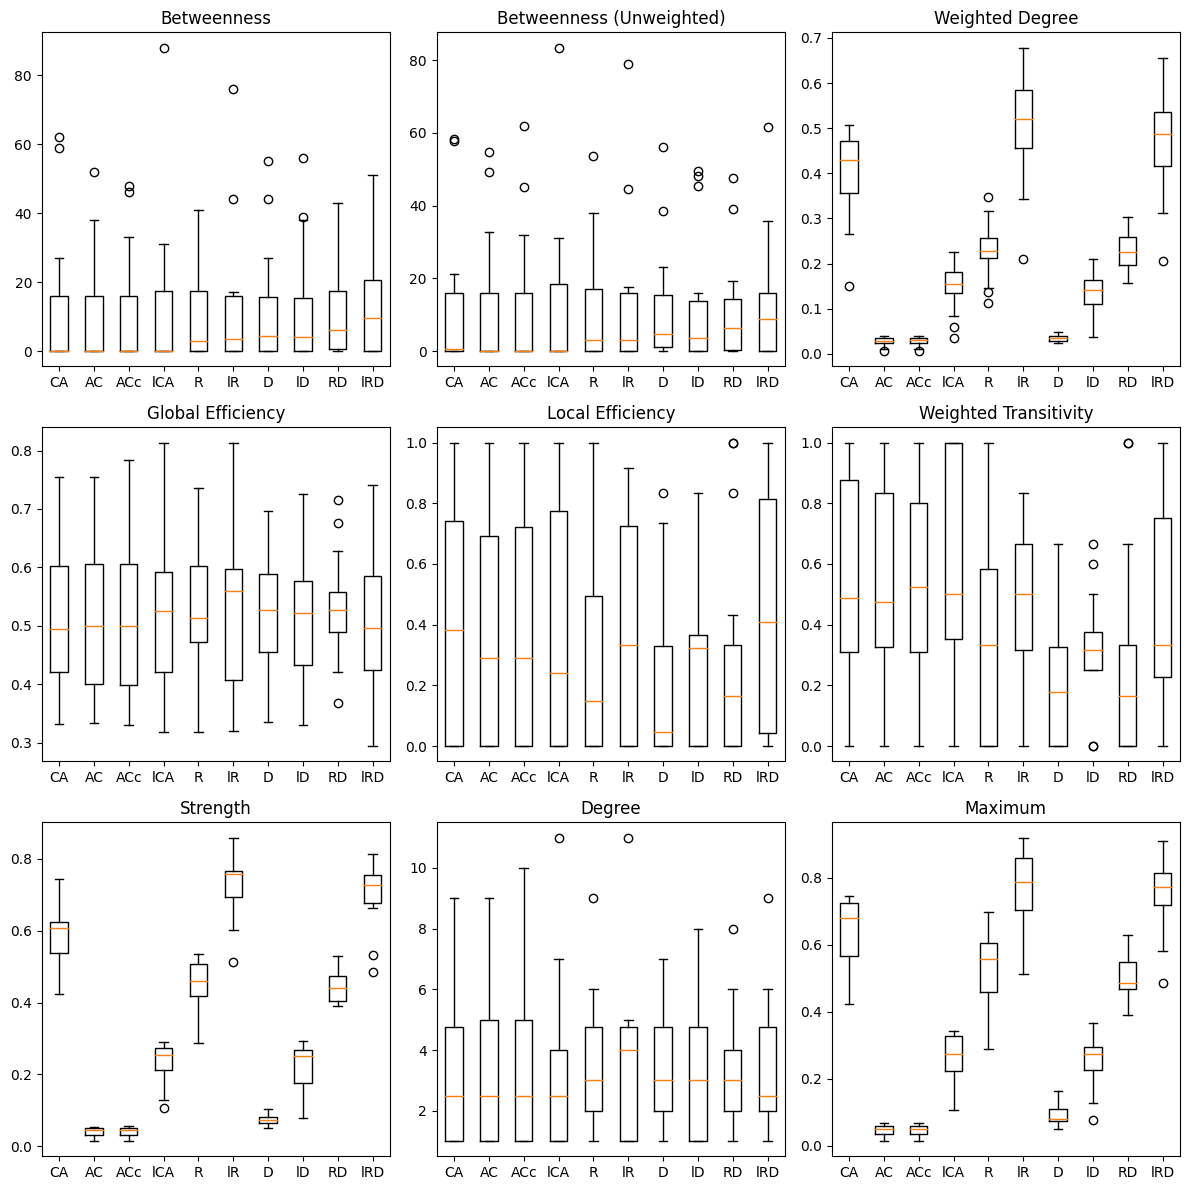

In [12]:
# Create a grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Plot boxplots for betweenness centrality
axs[0, 0].boxplot(betweeenness_list)
axs[0, 0].set_title('Betweenness')
axs[0, 0].set_xticklabels(estimators)

axs[0, 1].boxplot(betweeenness_unw_list)
axs[0, 1].set_title('Betweenness (Unweighted)')
axs[0, 1].set_xticklabels(estimators)

# Plot boxplots for weighted degree
axs[0, 2].boxplot(weighted_degree_list)
axs[0, 2].set_title('Weighted Degree')
axs[0, 2].set_xticklabels(estimators)

# Plot boxplots for global efficiency
axs[1, 0].boxplot(global_efficiency_list)
axs[1, 0].set_title('Global Efficiency')
axs[1, 0].set_xticklabels(estimators)

# Plot boxplots for local efficiency
axs[1, 1].boxplot(local_efficiency_list)
axs[1, 1].set_title('Local Efficiency')
axs[1, 1].set_xticklabels(estimators)

# Plot boxplots for weighted transitivity
axs[1, 2].boxplot(weighted_transitivity_list)
axs[1, 2].set_title('Weighted Transitivity')
axs[1, 2].set_xticklabels(estimators)

# Plot boxplots for strength
axs[2, 0].boxplot(strength_list)
axs[2, 0].set_title('Strength')
axs[2, 0].set_xticklabels(estimators)

# Plot boxplots for degree
axs[2, 1].boxplot(degree_list)
axs[2, 1].set_title('Degree')
axs[2, 1].set_xticklabels(estimators)

# Plot boxplots for maximum value
axs[2, 2].boxplot(maximum_list)
axs[2, 2].set_title('Maximum')
axs[2, 2].set_xticklabels(estimators)

# Adjust spacing between subplots
plt.tight_layout()

# Save the plot as a PDF file
plt.savefig('res_graph_metrics.pdf')

# Display the plot
plt.show()